<a href="https://colab.research.google.com/github/heimmer/ML2022-Spring/blob/main/HW03/HW03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW3 Image Classification
## We strongly recommend that you run with Kaggle for this homework


# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [1]:
! wget https://www.dropbox.com/s/6l2vcvxl54b0b6w/food11.zip

--2023-10-11 09:33:15--  https://www.dropbox.com/s/6l2vcvxl54b0b6w/food11.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/6l2vcvxl54b0b6w/food11.zip [following]
--2023-10-11 09:33:15--  https://www.dropbox.com/s/raw/6l2vcvxl54b0b6w/food11.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0bbdd07293fdd07143f3ea13bd.dl.dropboxusercontent.com/cd/0/inline/CFZZHEOkXnutPFkcmcwg91vLEz9f66ypNtcd_qeHEn8d1E5gPYi72YbLBqlor9VEmH0IOP428eW4DoZyxL0JRgheM6A4CevscYyUcRQ8AJlV6rVq_e8oRIoQA1m9lkS-fIRpxpVuoMKbr2MeR9CFNDwG/file# [following]
--2023-10-11 09:33:15--  https://uc0bbdd07293fdd07143f3ea13bd.dl.dropboxusercontent.com/cd/0/inline/CFZZHEOkXnutPFkcmcwg91vLEz9f66ypNtcd_qeHEn8d1E5gPYi72YbLBqlor9VEmH0IOP428eW4DoZyxL0JRgheM6A4CevscYyUcRQ8AJlV

In [2]:
! unzip food11.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: food11/training/8_806.jpg  
  inflating: food11/training/8_807.jpg  
  inflating: food11/training/8_808.jpg  
  inflating: food11/training/8_809.jpg  
  inflating: food11/training/8_81.jpg  
  inflating: food11/training/8_810.jpg  
  inflating: food11/training/8_811.jpg  
  inflating: food11/training/8_812.jpg  
  inflating: food11/training/8_813.jpg  
  inflating: food11/training/8_814.jpg  
  inflating: food11/training/8_815.jpg  
  inflating: food11/training/8_816.jpg  
  inflating: food11/training/8_817.jpg  
  inflating: food11/training/8_818.jpg  
  inflating: food11/training/8_819.jpg  
  inflating: food11/training/8_82.jpg  
  inflating: food11/training/8_820.jpg  
  inflating: food11/training/8_821.jpg  
  inflating: food11/training/8_822.jpg  
  inflating: food11/training/8_823.jpg  
  inflating: food11/training/8_824.jpg  
  inflating: food11/training/8_825.jpg  
  inflating: food11/training/8_826.jpg  
  inflating: food11/training/8_8

# import

In [3]:
_exp_name = "sample"

In [4]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as v2
from PIL import Image

# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [5]:
myseed = 6666  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# **Transforms**
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

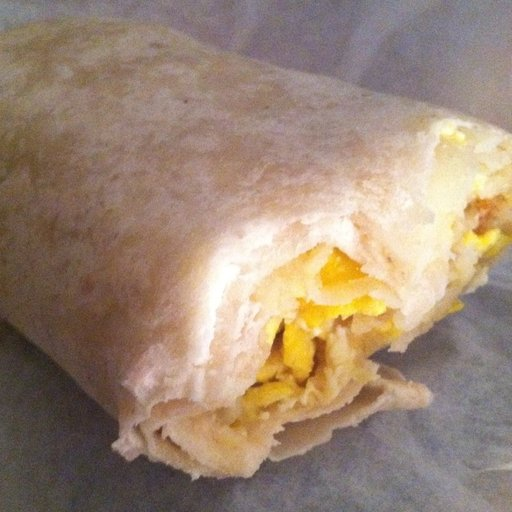

In [6]:
# test augmentations
img = Image.open('/content/food11/validation/0_1.jpg')
img

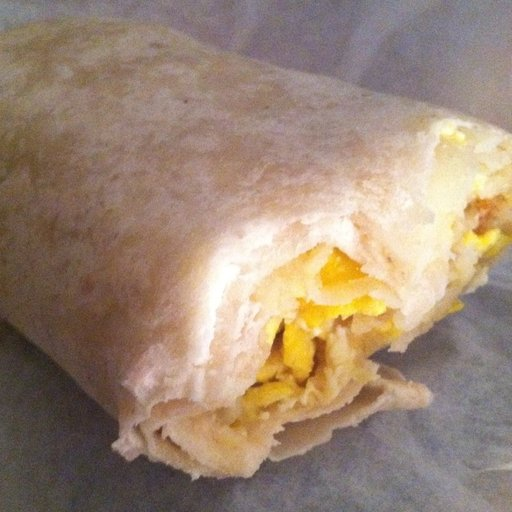

In [7]:
transform = v2.RandomGrayscale()
out = transform(img)
out

In [8]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
train_tfm = v2.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    v2.Resize((128, 128)),
    # You may add some transforms here.
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(),
    # v2.Pad(36),
    v2.RandomRotation(np.random.randint(0,360)),
    v2.RandomPerspective(),
    v2.RandomGrayscale(),
    # ToTensor() should be the last one of the transforms.
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
test_tfm = v2.Compose([
    v2.Resize((128, 128)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(np.random.randint(0,360)),
    v2.RandomPerspective(),
    v2.RandomGrayscale(),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# **Datasets**
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [9]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm

    def __len__(self):
        return len(self.files)

    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        #im = self.data[idx]
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label



# model

## CNN

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

## CNN + ResidualBlock
![](https://i.imgur.com/GYsq1Ap.png)

In [11]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=11):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(ResidualBlock, [3, 4, 6, 3])


# Training

In [12]:
batch_size = 32
_dataset_dir = "./food11"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset(os.path.join(_dataset_dir,"training"), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset(os.path.join(_dataset_dir,"validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

One ./food11/training sample ./food11/training/0_0.jpg
One ./food11/validation sample ./food11/validation/0_0.jpg


In [13]:
# # a =[]
# # for i,(t,label) in enumerate(train_set):
# #   a.append(label)
# max(a)

In [14]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# The number of training epochs and patience.
n_epochs = 50
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model = ResNet18().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 001/050 ] loss = 2.12447, acc = 0.24506


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 001/050 ] loss = 2.04703, acc = 0.27797
[ Valid | 001/050 ] loss = 2.04703, acc = 0.27797 -> best
Best model found at epoch 0, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 002/050 ] loss = 2.00347, acc = 0.29498


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 002/050 ] loss = 1.99647, acc = 0.31192
[ Valid | 002/050 ] loss = 1.99647, acc = 0.31192 -> best
Best model found at epoch 1, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 003/050 ] loss = 1.91695, acc = 0.33119


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 003/050 ] loss = 1.83988, acc = 0.36400
[ Valid | 003/050 ] loss = 1.83988, acc = 0.36400 -> best
Best model found at epoch 2, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 004/050 ] loss = 1.83547, acc = 0.37160


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 004/050 ] loss = 1.82828, acc = 0.35311
[ Valid | 004/050 ] loss = 1.82828, acc = 0.35311


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 005/050 ] loss = 1.77972, acc = 0.38287


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 005/050 ] loss = 2.01955, acc = 0.34192
[ Valid | 005/050 ] loss = 2.01955, acc = 0.34192


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 006/050 ] loss = 1.72786, acc = 0.40817


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 006/050 ] loss = 1.69890, acc = 0.43036
[ Valid | 006/050 ] loss = 1.69890, acc = 0.43036 -> best
Best model found at epoch 5, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 007/050 ] loss = 1.67330, acc = 0.42522


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 007/050 ] loss = 2.00199, acc = 0.35388
[ Valid | 007/050 ] loss = 2.00199, acc = 0.35388


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 008/050 ] loss = 1.65945, acc = 0.43738


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 008/050 ] loss = 1.60201, acc = 0.45988
[ Valid | 008/050 ] loss = 1.60201, acc = 0.45988 -> best
Best model found at epoch 7, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 009/050 ] loss = 1.58310, acc = 0.46090


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 009/050 ] loss = 1.83802, acc = 0.39361
[ Valid | 009/050 ] loss = 1.83802, acc = 0.39361


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 010/050 ] loss = 1.54578, acc = 0.47571


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 010/050 ] loss = 1.78097, acc = 0.41416
[ Valid | 010/050 ] loss = 1.78097, acc = 0.41416


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 011/050 ] loss = 1.49748, acc = 0.49816


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 011/050 ] loss = 1.55011, acc = 0.47550
[ Valid | 011/050 ] loss = 1.55011, acc = 0.47550 -> best
Best model found at epoch 10, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 012/050 ] loss = 1.45700, acc = 0.50117


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 012/050 ] loss = 1.52305, acc = 0.48457
[ Valid | 012/050 ] loss = 1.52305, acc = 0.48457 -> best
Best model found at epoch 11, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 013/050 ] loss = 1.42678, acc = 0.51709


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 013/050 ] loss = 1.52308, acc = 0.49238
[ Valid | 013/050 ] loss = 1.52308, acc = 0.49238 -> best
Best model found at epoch 12, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 014/050 ] loss = 1.38114, acc = 0.52828


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 014/050 ] loss = 1.39229, acc = 0.53501
[ Valid | 014/050 ] loss = 1.39229, acc = 0.53501 -> best
Best model found at epoch 13, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 015/050 ] loss = 1.34714, acc = 0.54324


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 015/050 ] loss = 1.36381, acc = 0.53839
[ Valid | 015/050 ] loss = 1.36381, acc = 0.53839 -> best
Best model found at epoch 14, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 016/050 ] loss = 1.30180, acc = 0.55878


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 016/050 ] loss = 1.32086, acc = 0.56838
[ Valid | 016/050 ] loss = 1.32086, acc = 0.56838 -> best
Best model found at epoch 15, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 017/050 ] loss = 1.28375, acc = 0.56139


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 017/050 ] loss = 1.43204, acc = 0.52305
[ Valid | 017/050 ] loss = 1.43204, acc = 0.52305


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 018/050 ] loss = 1.25951, acc = 0.57579


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 018/050 ] loss = 1.40485, acc = 0.53414
[ Valid | 018/050 ] loss = 1.40485, acc = 0.53414


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 019/050 ] loss = 1.22236, acc = 0.58212


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 019/050 ] loss = 1.32926, acc = 0.56780
[ Valid | 019/050 ] loss = 1.32926, acc = 0.56780


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 020/050 ] loss = 1.18055, acc = 0.59644


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 020/050 ] loss = 1.24970, acc = 0.57899
[ Valid | 020/050 ] loss = 1.24970, acc = 0.57899 -> best
Best model found at epoch 19, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 021/050 ] loss = 1.17000, acc = 0.59741


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 021/050 ] loss = 1.42854, acc = 0.53665
[ Valid | 021/050 ] loss = 1.42854, acc = 0.53665


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 022/050 ] loss = 1.13989, acc = 0.60805


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 022/050 ] loss = 1.21703, acc = 0.58825
[ Valid | 022/050 ] loss = 1.21703, acc = 0.58825 -> best
Best model found at epoch 21, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 023/050 ] loss = 1.11848, acc = 0.61822


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 023/050 ] loss = 1.17035, acc = 0.61844
[ Valid | 023/050 ] loss = 1.17035, acc = 0.61844 -> best
Best model found at epoch 22, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 024/050 ] loss = 1.10159, acc = 0.62998


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 024/050 ] loss = 1.42111, acc = 0.52691
[ Valid | 024/050 ] loss = 1.42111, acc = 0.52691


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 025/050 ] loss = 1.07969, acc = 0.63331


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 025/050 ] loss = 1.19449, acc = 0.61063
[ Valid | 025/050 ] loss = 1.19449, acc = 0.61063


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 026/050 ] loss = 1.04966, acc = 0.64039


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 026/050 ] loss = 1.35300, acc = 0.55276
[ Valid | 026/050 ] loss = 1.35300, acc = 0.55276


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 027/050 ] loss = 1.03485, acc = 0.64640


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 027/050 ] loss = 1.14253, acc = 0.63310
[ Valid | 027/050 ] loss = 1.14253, acc = 0.63310 -> best
Best model found at epoch 26, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 028/050 ] loss = 1.00791, acc = 0.66365


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 028/050 ] loss = 1.16097, acc = 0.61564
[ Valid | 028/050 ] loss = 1.16097, acc = 0.61564


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 029/050 ] loss = 0.99820, acc = 0.66017


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 029/050 ] loss = 1.11671, acc = 0.62095
[ Valid | 029/050 ] loss = 1.11671, acc = 0.62095


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 030/050 ] loss = 0.98576, acc = 0.66390


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 030/050 ] loss = 1.18123, acc = 0.60812
[ Valid | 030/050 ] loss = 1.18123, acc = 0.60812


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 031/050 ] loss = 0.94824, acc = 0.67714


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 031/050 ] loss = 1.32618, acc = 0.56221
[ Valid | 031/050 ] loss = 1.32618, acc = 0.56221


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 032/050 ] loss = 0.94103, acc = 0.68214


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 032/050 ] loss = 1.42272, acc = 0.55392
[ Valid | 032/050 ] loss = 1.42272, acc = 0.55392


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 033/050 ] loss = 0.92823, acc = 0.68190


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 033/050 ] loss = 1.21434, acc = 0.60639
[ Valid | 033/050 ] loss = 1.21434, acc = 0.60639


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 034/050 ] loss = 0.91180, acc = 0.69288


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 034/050 ] loss = 1.12575, acc = 0.64275
[ Valid | 034/050 ] loss = 1.12575, acc = 0.64275 -> best
Best model found at epoch 33, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 035/050 ] loss = 0.89374, acc = 0.69559


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 035/050 ] loss = 1.03152, acc = 0.66503
[ Valid | 035/050 ] loss = 1.03152, acc = 0.66503 -> best
Best model found at epoch 34, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 036/050 ] loss = 0.88831, acc = 0.69897


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 036/050 ] loss = 1.02977, acc = 0.67052
[ Valid | 036/050 ] loss = 1.02977, acc = 0.67052 -> best
Best model found at epoch 35, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 037/050 ] loss = 0.86970, acc = 0.70354


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 037/050 ] loss = 1.00402, acc = 0.67631
[ Valid | 037/050 ] loss = 1.00402, acc = 0.67631 -> best
Best model found at epoch 36, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 038/050 ] loss = 0.86672, acc = 0.70512


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 038/050 ] loss = 1.18490, acc = 0.61941
[ Valid | 038/050 ] loss = 1.18490, acc = 0.61941


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 039/050 ] loss = 0.84549, acc = 0.70999


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 039/050 ] loss = 1.11716, acc = 0.64352
[ Valid | 039/050 ] loss = 1.11716, acc = 0.64352


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 040/050 ] loss = 0.84377, acc = 0.71596


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 040/050 ] loss = 1.01714, acc = 0.66262
[ Valid | 040/050 ] loss = 1.01714, acc = 0.66262


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 041/050 ] loss = 0.83178, acc = 0.71568


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 041/050 ] loss = 0.97294, acc = 0.67612
[ Valid | 041/050 ] loss = 0.97294, acc = 0.67612


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 042/050 ] loss = 0.80585, acc = 0.72658


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 042/050 ] loss = 1.09221, acc = 0.65770
[ Valid | 042/050 ] loss = 1.09221, acc = 0.65770


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 043/050 ] loss = 0.80394, acc = 0.73111


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 043/050 ] loss = 0.89392, acc = 0.70959
[ Valid | 043/050 ] loss = 0.89392, acc = 0.70959 -> best
Best model found at epoch 42, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 044/050 ] loss = 0.78824, acc = 0.73400


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 044/050 ] loss = 1.07280, acc = 0.65577
[ Valid | 044/050 ] loss = 1.07280, acc = 0.65577


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 045/050 ] loss = 0.76842, acc = 0.74047


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 045/050 ] loss = 0.95985, acc = 0.69377
[ Valid | 045/050 ] loss = 0.95985, acc = 0.69377


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 046/050 ] loss = 0.77111, acc = 0.73503


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 046/050 ] loss = 1.07424, acc = 0.66426
[ Valid | 046/050 ] loss = 1.07424, acc = 0.66426


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 047/050 ] loss = 0.75177, acc = 0.74757


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 047/050 ] loss = 0.94028, acc = 0.69377
[ Valid | 047/050 ] loss = 0.94028, acc = 0.69377


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 048/050 ] loss = 0.73270, acc = 0.75309


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 048/050 ] loss = 0.91658, acc = 0.71277
[ Valid | 048/050 ] loss = 0.91658, acc = 0.71277 -> best
Best model found at epoch 47, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 049/050 ] loss = 0.73630, acc = 0.75075


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 049/050 ] loss = 0.84351, acc = 0.72126
[ Valid | 049/050 ] loss = 0.84351, acc = 0.72126 -> best
Best model found at epoch 48, saving model


  0%|          | 0/309 [00:00<?, ?it/s]

[ Train | 050/050 ] loss = 0.73666, acc = 0.74486


  0%|          | 0/108 [00:00<?, ?it/s]

[ Valid | 050/050 ] loss = 0.93362, acc = 0.70390
[ Valid | 050/050 ] loss = 0.93362, acc = 0.70390


In [15]:
test_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

One ./food11/test sample ./food11/test/0001.jpg


# Testing and generate prediction CSV

In [16]:
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in test_loader:
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

RuntimeError: ignored

In [ ]:
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(1,len(test_set)+1)]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice.
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [ ]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You need to add some transforms here.
    transforms.ToTensor(),
])

# Q2. Residual Implementation
![](https://i.imgur.com/GYsq1Ap.png)
## Directly copy the following block and paste it on GradeScope after you finish the code


In [ ]:
from torch import nn
class Residual_Network(nn.Module):
    def __init__(self):
        super(Residual_Network, self).__init__()

        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
        )

        self.cnn_layer4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
        )
        self.cnn_layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
        )
        self.cnn_layer6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(256* 32* 32, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x1 = self.cnn_layer1(x)

        x1 = self.relu(x1)

        x2 = self.cnn_layer2(x1)

        x2 = self.relu(x2)

        x3 = self.cnn_layer3(x2)

        x3 = self.relu(x3)

        x4 = self.cnn_layer4(x3)

        x4 = self.relu(x4)

        x5 = self.cnn_layer5(x4)

        x5 = self.relu(x5)

        x6 = self.cnn_layer6(x5)

        x6 = self.relu(x6)

        # The extracted feature map must be flatten before going to fully-connected layers.
        xout = x6.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        xout = self.fc_layer(xout)
        return xout